In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

['digit-recognizer']


In [2]:
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X_train = df_train.iloc[:, 1:]
Y_train = df_train.iloc[:, 0]

In [3]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [5]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [6]:
# Normalize inputs
X_train = X_train / 250.0

In [7]:
def plot_digits(X, Y):
    for i in range(20):
        plt.subplot(5, 4, i+1)
        plt.tight_layout()
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title('Digit:{}'.format(Y[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

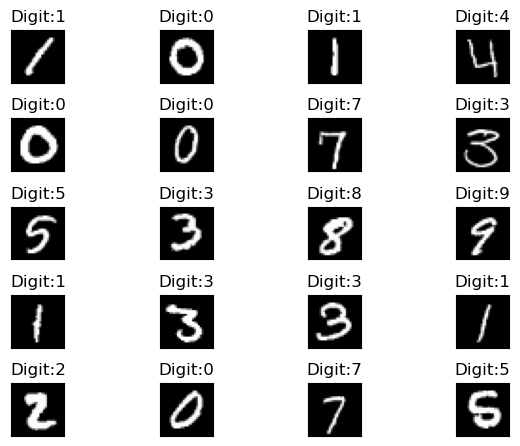

In [8]:
plot_digits(X_train, Y_train)

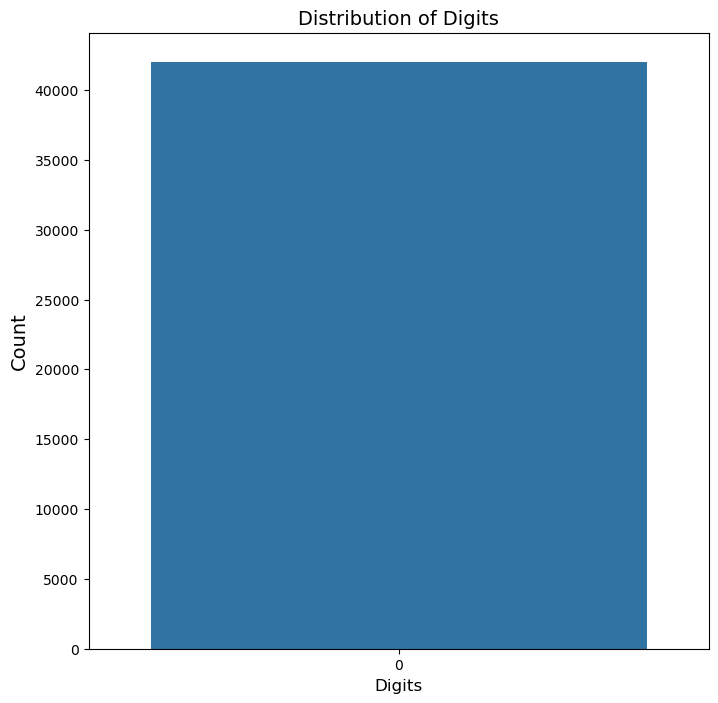

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(Y_train)
ax.set_title('Distribution of Digits', fontsize=14)
ax.set_xlabel('Digits', fontsize=12)
ax.set_ylabel('Count', fontsize=14)
plt.show()

In [10]:
#Train-Test Split
X_dev, X_val, Y_dev, Y_val = train_test_split(X_train, Y_train, test_size=0.03, shuffle=True, random_state=2019)
T_dev = pd.get_dummies(Y_dev).values
T_val = pd.get_dummies(Y_val).values

In [11]:
#Reshape the input 
X_dev = X_dev.reshape(X_dev.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [13]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [14]:
adam = Adam(lr=5e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# Set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [16]:
# Data Augmentation
datagen = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.1)
datagen.fit(X_dev)

In [17]:
model.fit(datagen.flow(X_dev, T_dev, batch_size=100), steps_per_epoch=len(X_dev)/100, 
                    epochs=30, validation_data=(X_val, T_val), callbacks=[reduce_lr])

Epoch 1/30
407/407 [==============================] - 25s 59ms/step - loss: 0.4512 - accuracy: 0.8628 - val_loss: 0.1139 - val_accuracy: 0.9635 - lr: 5.0000e-04
Epoch 2/30
407/407 [==============================] - 24s 58ms/step - loss: 0.1418 - accuracy: 0.9568 - val_loss: 0.0723 - val_accuracy: 0.9738 - lr: 5.0000e-04
Epoch 3/30
407/407 [==============================] - 24s 59ms/step - loss: 0.1030 - accuracy: 0.9696 - val_loss: 0.0527 - val_accuracy: 0.9841 - lr: 5.0000e-04
Epoch 4/30
407/407 [==============================] - 24s 59ms/step - loss: 0.0807 - accuracy: 0.9748 - val_loss: 0.0605 - val_accuracy: 0.9817 - lr: 5.0000e-04
Epoch 5/30
407/407 [==============================] - 24s 59ms/step - loss: 0.0696 - accuracy: 0.9783 - val_loss: 0.0381 - val_accuracy: 0.9857 - lr: 5.0000e-04
Epoch 6/30
407/407 [==============================] - 24s 58ms/step - loss: 0.0604 - accuracy: 0.9808 - val_loss: 0.0503 - val_accuracy: 0.9849 - lr: 5.0000e-04
Epoch 7/30
407/407 [==============

In [18]:
score = model.evaluate(X_val, T_val, batch_size=32)

40/40 [==============================] - 0s 7ms/step - loss: 0.0124 - accuracy: 0.9952


In [19]:
score

[0.01243568304926157, 0.9952380657196045]

In [20]:
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X_test = np.array(df_test)
X_test = X_test/255.0

In [21]:
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
Y_test = model.predict(X_test)

875/875 [==============================] - 6s 7ms/step


In [22]:
Y_test = np.argmax(Y_test, axis=1)
Y_test[:5]

array([2, 0, 9, 0, 3])

In [23]:
df_out = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
df_out['Label'] = Y_test
df_out.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [24]:
df_out.to_csv('out.csv', index=False)